In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import helpers as hp

In [3]:
commands, nums = hp.get_commands_dict('commands.csv')

In [4]:
all_speakers = ['speaker1', 'speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']
dataset = dict()
for speaker in all_speakers:
    data = hp.load_from_datafile(f'data/{speaker}_data.npy')
    labels = hp.load_from_datafile(f'data/{speaker}_labels.npy')

    data = data.reshape(data.shape + (1,))
    labels = to_categorical([hp.get_num_by_command(label, commands) for label in labels], num_classes=11)
    idx = np.random.permutation(data.shape[0])
    data, labels = data[idx], labels[idx]
    
    dataset[speaker] = {
        'data':   data,
        'labels': labels 
    }
    
    print(dataset[speaker]['data'].shape)
    print(dataset[speaker]['labels'].shape)

(550, 400, 13, 1)
(550, 11)
(440, 400, 13, 1)
(440, 11)
(440, 400, 13, 1)
(440, 11)
(500, 400, 13, 1)
(500, 11)
(550, 400, 13, 1)
(550, 11)
(550, 400, 13, 1)
(550, 11)


## Experiment 1 
### Train on speaker 1 and test on each of others

Keras Model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 5200)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               1331456   
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 11)                715       
Total params: 1,389,835
Trainable params: 1,389,835
Non-trainable params: 0
______________________________________________

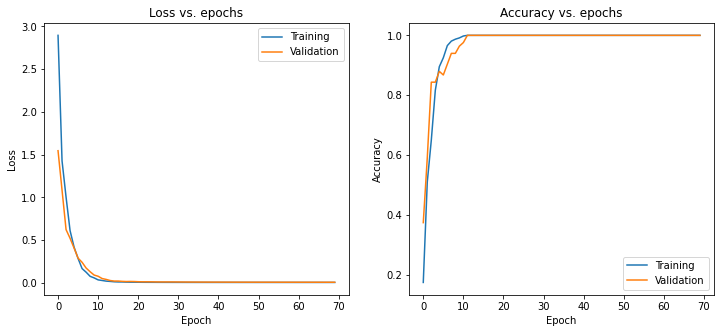

In [5]:
model = hp.get_model()
model.summary()
model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])

checkpoint_best_only = ModelCheckpoint(save_freq="epoch", save_best_only=True,
                                       filepath="model_checkpoints/experiment1/mlp/best_only") 
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1)

history = model.fit(dataset['speaker1']['data'], dataset['speaker1']['labels'], epochs=70, batch_size=256, validation_split=0.15, 
                    callbacks=[early_stopping, checkpoint_best_only], 
                    verbose=2)

hp.plot_metrics(history)

speaker1 - test loss: 0.005 - test accuracy: 1.000
(11, 12)
(11, 12)


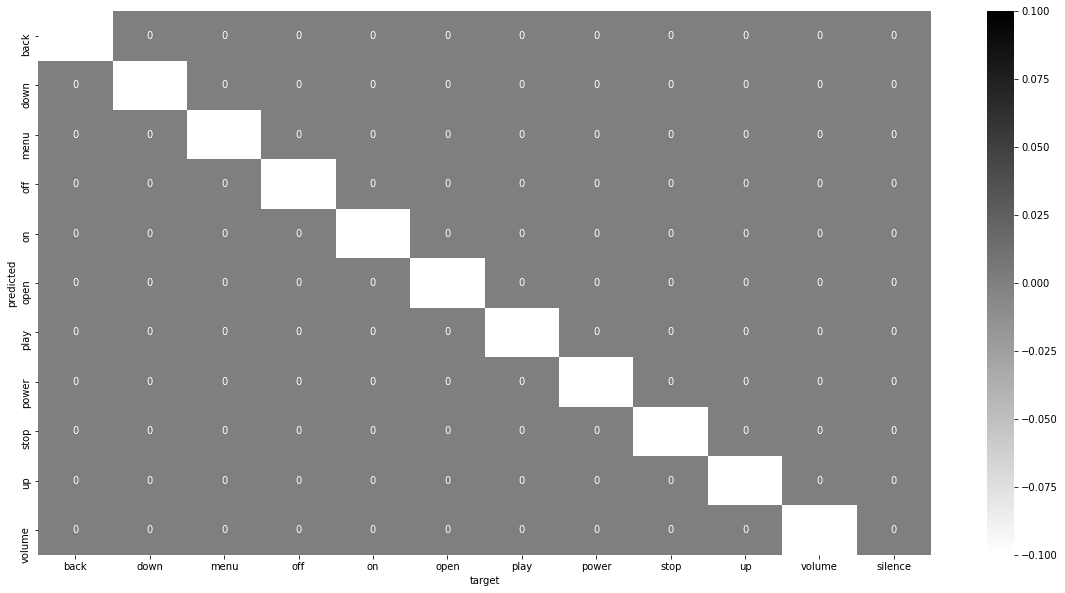

--------------------------------------------------------------------------
speaker2 - test loss: 7.642 - test accuracy: 0.168
(11, 12)
(11, 12)


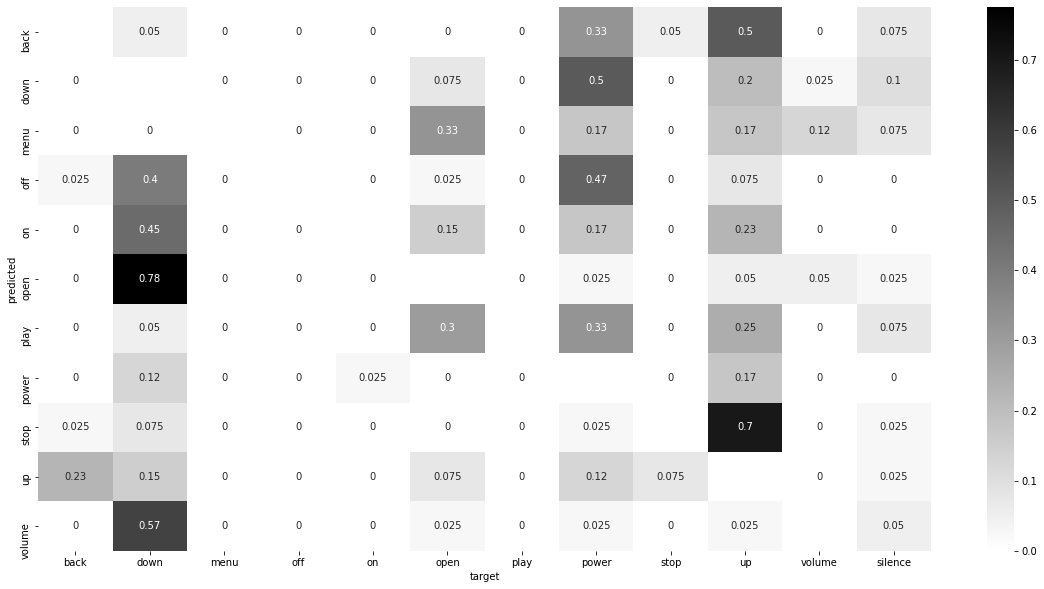

--------------------------------------------------------------------------
speaker3 - test loss: 2.730 - test accuracy: 0.452
(11, 12)
(11, 12)


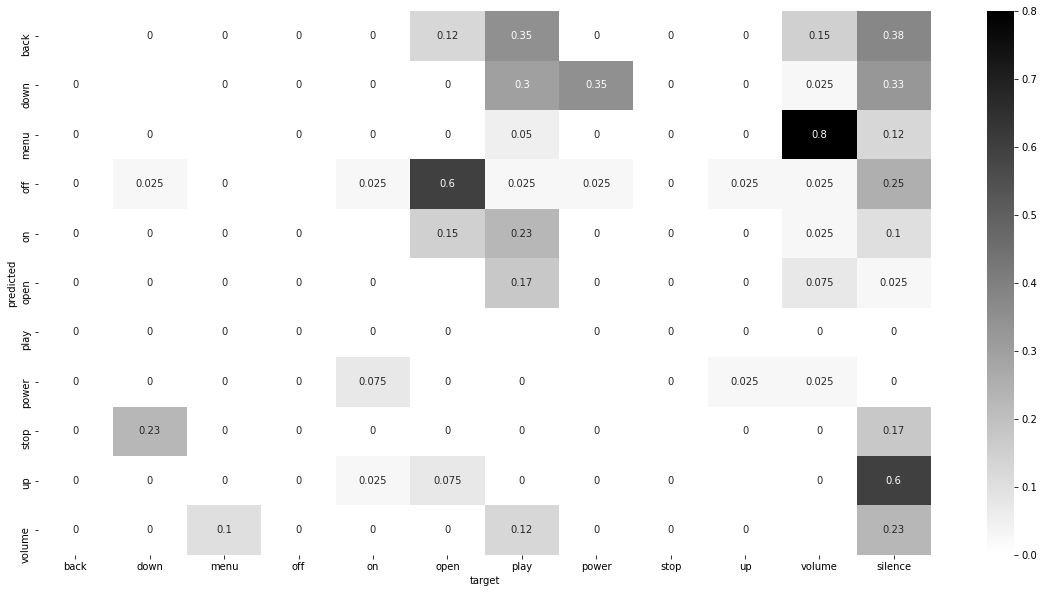

--------------------------------------------------------------------------
speaker4 - test loss: 7.411 - test accuracy: 0.236
(11, 12)
(11, 12)


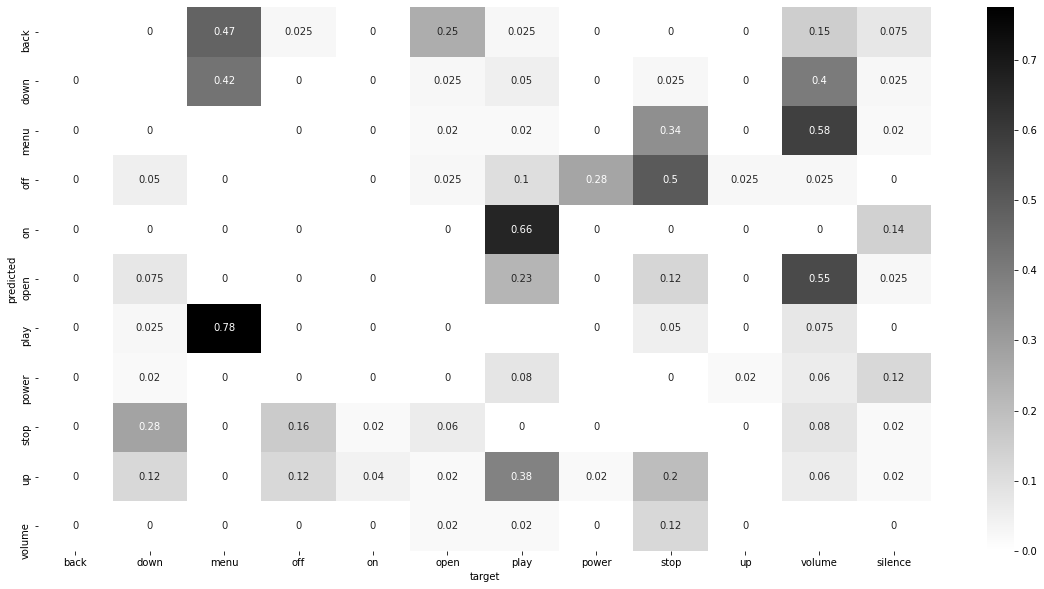

--------------------------------------------------------------------------
speaker5 - test loss: 2.909 - test accuracy: 0.576
(11, 12)
(11, 12)


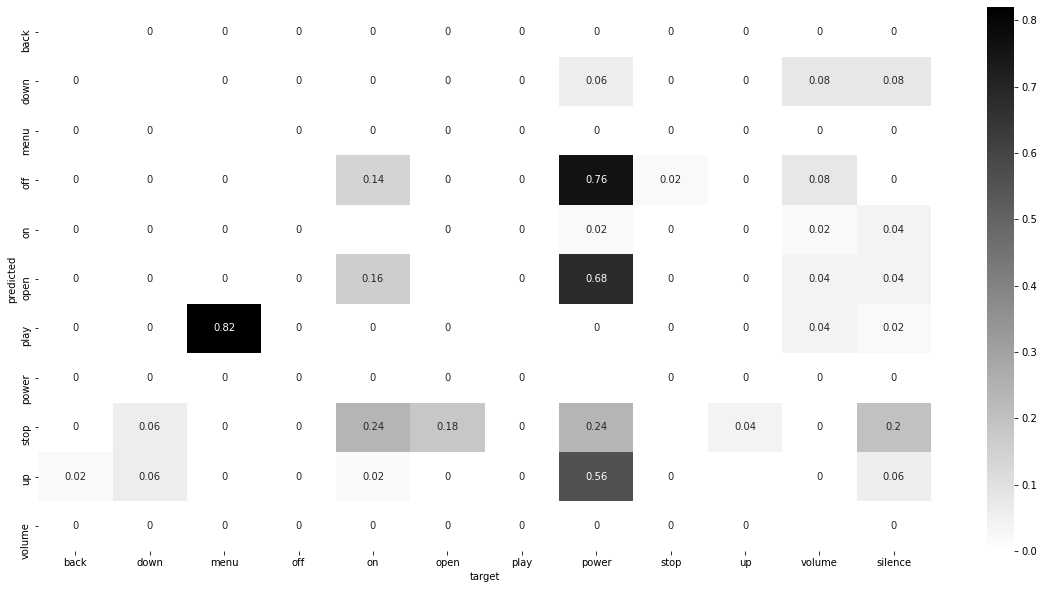

--------------------------------------------------------------------------
speaker6 - test loss: 7.965 - test accuracy: 0.151
(11, 12)
(11, 12)


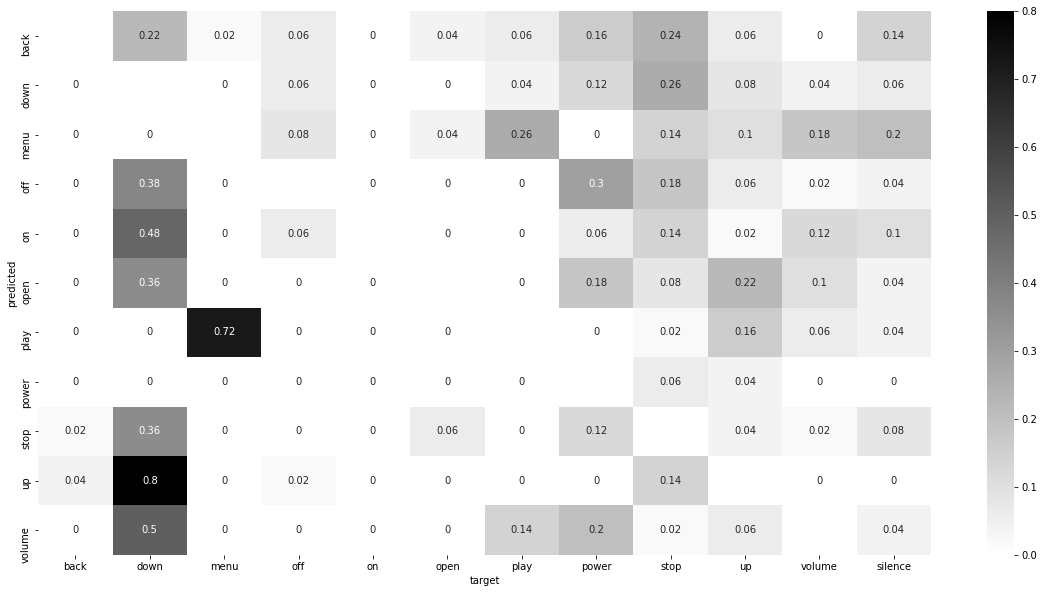

--------------------------------------------------------------------------


In [19]:
for speaker in all_speakers:
    test_loss, test_accuracy = model.evaluate(dataset[speaker]['data'], dataset[speaker]['labels'], verbose=0)
    print(f"{speaker} - test loss: {test_loss:0.3f} - test accuracy: {test_accuracy:0.3f}")
    
    confusion_matrix = hp.get_confusion_matrix(dataset[speaker]['labels'], model.predict(dataset[speaker]['data']), nums, threshold=0.5)
    hp.plot_confusion_matrix(confusion_matrix)
    print('-'*74)

## Experiment 2
### Train on all speakers and test on each speaker

Creating train and test data

In [ ]:
test_size = 0.3

In [ ]:
train_data = dataset['speaker1']['data'][:np.floor(dataset['speaker1']['data'].shape[0]*(1-test_size)).astype(int), ...]
train_labels = dataset['speaker1']['labels'][:np.floor(dataset['speaker1']['labels'].shape[0]*(1-test_size)).astype(int), ...]

test_dict = {
    'speaker1': {
        'data': dataset['speaker1']['data'][np.floor(dataset['speaker1']['data'].shape[0]*(1-test_size)).astype(int):, ...],
        'labels': dataset['speaker1']['labels'][np.floor(dataset['speaker1']['labels'].shape[0]*(1-test_size)).astype(int):, ...]
    }
}

for speaker in ['speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']:
    train_data = np.append(train_data, dataset[speaker]['data'][:np.floor(dataset[speaker]['data'].shape[0]*(1-test_size)).astype(int), ...], axis=0)
    train_labels = np.append(train_labels, dataset[speaker]['labels'][:np.floor(dataset[speaker]['labels'].shape[0]*(1-test_size)).astype(int), ...], axis=0)
    test_dict[speaker] = {
        'data': dataset[speaker]['data'][np.floor(dataset[speaker]['data'].shape[0]*(1-test_size)).astype(int):, ...] ,
        'labels': dataset[speaker]['labels'][np.floor(dataset[speaker]['labels'].shape[0]*(1-test_size)).astype(int):, ...]
    }

print(f'Train data shape : {train_data.shape}')
print(f'Train labels shape : {train_labels.shape}')
for speaker in ['speaker2', 'speaker3', 'speaker4', 'speaker5', 'speaker6']:
    print(f'{speaker} test data shape : {test_dict[speaker]["data"].shape}')
    print(f'{speaker} test labels shape : {test_dict[speaker]["labels"].shape}')

Keras Model

In [ ]:
model = hp.get_model()
model.summary()
model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])

checkpoint_best_only = ModelCheckpoint(save_freq="epoch", save_best_only=True,
                                       filepath="model_checkpoints/experiment2/mlp/best_only") 
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1)

history = model.fit(train_data, train_labels, epochs=70, batch_size=256, validation_split=0.15, 
                    callbacks=[early_stopping, checkpoint_best_only], 
                    verbose=2)

hp.plot_metrics(history)

In [ ]:
for speaker in all_speakers:
    test_loss, test_accuracy = model.evaluate(test_dict[speaker]['data'], test_dict[speaker]['labels'], verbose=0)
    print(f"{speaker} - test loss: {test_loss:0.3f} - test accuracy: {test_accuracy:0.3f}")
    
    confusion_matrix = hp.get_confusion_matrix(test_dict[speaker]['labels'], model.predict(test_dict[speaker]['data']), len(nums), threshold=0.5)
    df = pd.DataFrame(data=confusion_matrix.numpy(), columns=hp.get_commands_list_with_silence(nums), index=hp.get_commands_list_with_silence(nums))
    df.drop(df.tail(1).index,inplace=True)
    display(df)
    print('-'*74)